In [1]:
# Allow some options on the plots (zoom, resize, save), /!\: have to wait to the end of the cell's execution before launch the next
# %matplotlib notebook
# standard plot inside the netbook, but no options available
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from os.path import join, exists, basename
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display, Markdown
import warnings
import sys
import pandas

from utils import _running_mean, boari_synth_song_error

sys.path.append('../model/')

import measures
from song_fitter import SongModel, get_scores
from synth import synthesize

sns.set_palette('colorblind')

In [2]:
path = '../model/res/gilles_rescaling_try_180612_182310/' # path of the repository with the results
# path = '../model/res/cluster_simulation_180523_184444/seed0+optimise_gesture_whole+gilles_fast_boari_short+on_alpha_silence_beta+default_coef+slow_dev+500_replay+50_conc+3_day_conc+20days/' # path of the repository with the results

if exists(join(path, 'aborted.txt')):
    warnings.warn('Aborted run')
if not exists(join(path, 'data.pkl')):
    warnings.warn('Run is not finished')

In [3]:
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f) # load the parameters used for the simulation

In [4]:
try:
    with open(join(path, 'desc.md'), 'r') as f:
        display(Markdown( '> ' + '\n> '.join(f.read().split("\n"))))
except FileNotFoundError:
    print('No desc for this run.')

No desc for this run.


# Simulation parameters

In [5]:
out = '| key | value |\n|---|---|\n' + '\n'.join(['| {} | {} |'.format(key, run_param[key]) for key in sorted(run_param.keys())])
display(Markdown(out))

| key | value |
|---|---|
| #comment | ['def of sin param : (a * t + b) * sin(phase + 2 * pi * t * f)', 'Format of each list', '```', '#alpha', 'a, b, phase, f  #sin 1', 'a, b, phase, f  #sin 2', 'a, b, phase, f  #sin 3', 'cst', '#beta', 'a, b, phase, f, cst', '```', 'really ugly way to comment in json, sorry.'] |
| bloat_weight | 0 |
| coefs | {'entropy': 1, 'am': 0, 'amplitude': 1, 'fm': 0, 'pitch': 0, 'goodness': 0} |
| commit | dd48842d96228fb279349db3d3ad12661f80fc03 |
| comp | linalg |
| concurrent | 3 |
| days | 20 |
| decay | linear |
| dev | [0.001, 0.001, 0.005, 1, 0.0005, 0.0005, 0.0005, 1, 5e-05, 5e-05, 0.005, 10, 0.005, 0.002, 0.002, 0.005, 1, 0.0005] |
| diversity_threshold | 500 |
| diversity_weight | 1.25 |
| dlm | optimise_gesture_whole |
| iter_per_train | 20 |
| maxs | [50, 4, 3.141592653589793, 40000, 50, 4, 3.141592653589793, 40000, 50, 5, 3.141592653589793, 40000, 10, 50, 3, 3.141592653589793, 1000, 2] |
| mins | [-50, 0, -3.141592653589793, 0, -50, 0, -3.141592653589793, 0, -50, 0, -3.141592653589793, 0, -5, -50, 0, -3.141592653589793, 0, -3] |
| name | gilles_rescaling_try |
| nb_pad | 3 |
| night_concurrent | 50 |
| nlm | mutate_microbial_diversity_uniform |
| prior | [0, 0, 3.141592653589793, 15, 0, 0, 0.39269908169872414, 45, 0, 0, 0, 5000, 1, 0, 0, 0, 0, 0.15] |
| replay | 500 |
| seed | 1528820590 |
| train_per_day | 100 |
| tutor | ../data/boari_short.wav |

# Tutor song

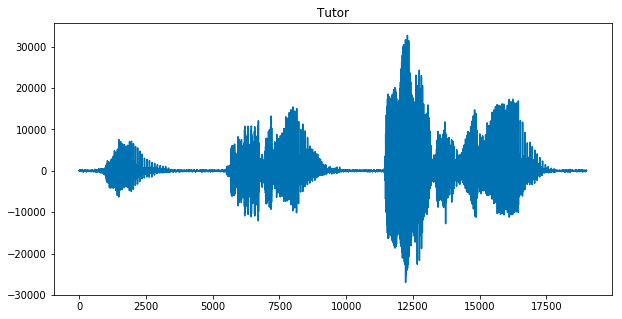

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(tutor)
plt.title("Tutor")
plt.show()

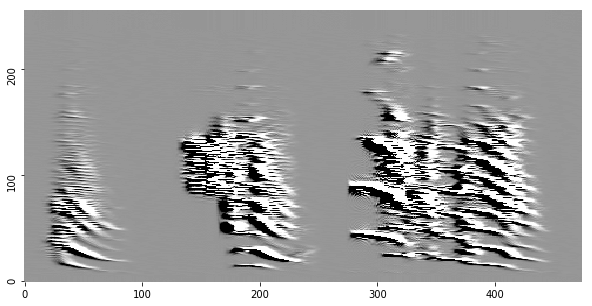

In [7]:
# Spectral derivative of the tutor song
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
plt.show(fig)

# Analysis of the learnt song

In [8]:
outputs = []
not_found = False
try:
    for i in range(run_param['concurrent']):
        outputs.append(wavfile.read(join(path, 'out_{}.wav'.format(i)))[1])
except FileNotFoundError:
    not_found = True

with open(join(path, 'data.pkl'), 'rb') as f:
    songlog = pickle.load(f)
    root_data = [item[1] for item in songlog if item[0] == 'root']
    rd = pandas.DataFrame(root_data)
    smodels = rd['songs'].iloc[-1]
    if not_found:
        outputs = [smodel.gen_sound() for smodel in smodels] # outputs contains the different final songs

In [9]:
# Sound of the tutor song
display(Audio(tutor, rate=44100))

In [36]:
# Audio of the final songs
for output in outputs:
    display(Audio(output, rate=44100))

In [11]:
run = False  # Disabled because very long.
if run:
    for out in outputs:
        sim = bsa.similarity(out, tutor)
        bsa.similarity_plot(sim, out, tutor)
        print(sim['similarity'])

In [12]:
tfeat = bsa.all_song_features(tutor, 44100, freq_range=256, fft_size=1024, fft_step=40)
best = np.argmin(rd['scores'].iloc[-1])
# get the features of the best song learnt
sfeat = bsa.all_song_features(outputs[best], 44100, freq_range=256, fft_size=1024, fft_step=40)

## Features comparison

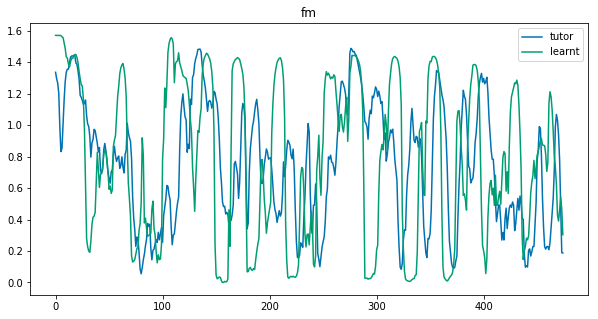

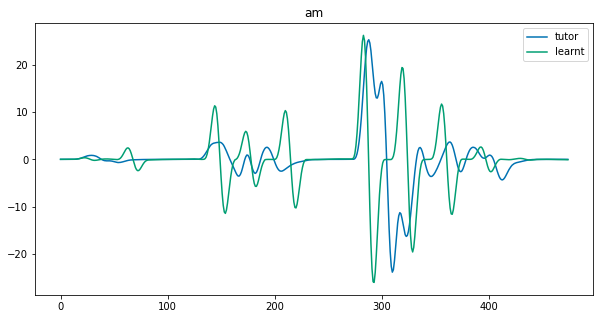

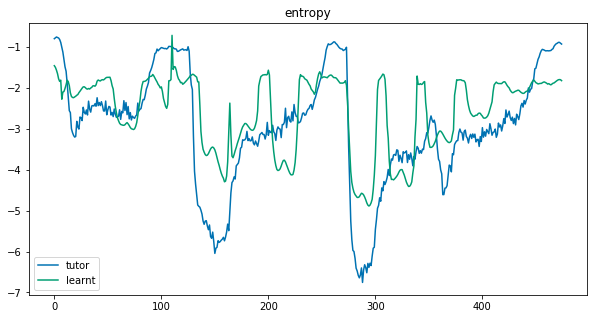

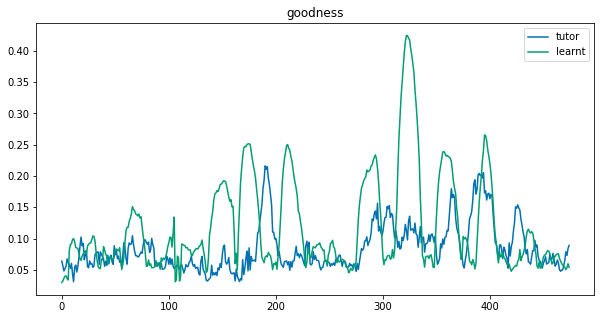

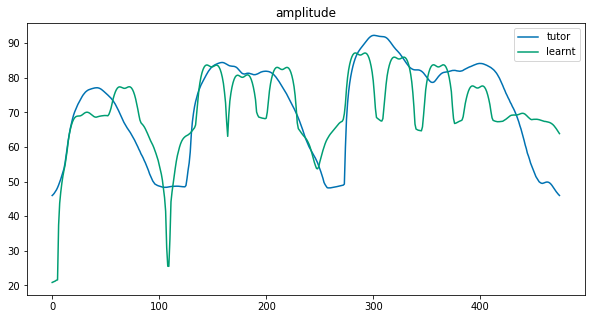

In [14]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N 

ntfeat = tfeat
nsfeat = sfeat

fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude']
for fname in fnames:
    plt.figure(figsize=(10, 5))
    plt.plot(running_mean(ntfeat[fname], 1), label="tutor")
    plt.plot(running_mean(nsfeat[fname], 1), label="learnt")
    plt.legend()
    plt.title(fname)
    plt.show()

# Gesture analysis

In [15]:
ab = smodels[0].gen_alphabeta()
for start, g in smodels[0].gestures:
    ab[start] = np.nan

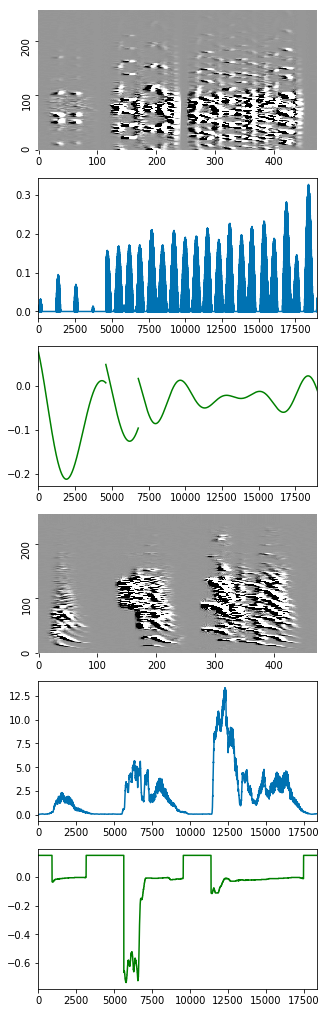

In [16]:
fig, axs = plt.subplots(6, 1, figsize=(5, 3*6))
ospec = bsa.spectral_derivs(outputs[0], 256, 40, 1024)
bsa.spectral_derivs_plot(ospec, contrast=0.01, ax=axs[0])
#bsa.plot_over_spec(sfeat['amplitude'], ax=axs[0])
axs[0].set_xlim(0, ospec.shape[0])
axs[1].plot(ab[:, 0])
axs[1].set_xlim((0, ab.shape[0]))
axs[2].plot(ab[:, 1], color="g")
axs[2].set_xlim((0, ab.shape[0]))
bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=axs[3])
#bsa.plot_over_spec(tfeat['amplitude'], ax=axs[3])

tutor_params = np.loadtxt('../data/{}_ab.dat'.format(basename(run_param['tutor']).split('.')[0]))
axs[4].plot(tutor_params[:, 0])
axs[4].set_xlim((0, tutor_params.shape[0]))
axs[5].plot(tutor_params[:, 1], c="g")
axs[5].set_xlim((0, tutor_params.shape[0]))

# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])


for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    #axs[0].axvline(x=start/40, color="k", linewidth=1)
    #axs[1].axvline(x=start, color="k", linewidth=1)
    #axs[2].axvline(x=start, color="k", linewidth=1)
    #axs[3].axvline(x=start/40, color="k", linewidth=1)
    #axs[4].axvline(x=start, color="k", linewidth=1)
    #axs[5].axvline(x=start, color="k", linewidth=1)

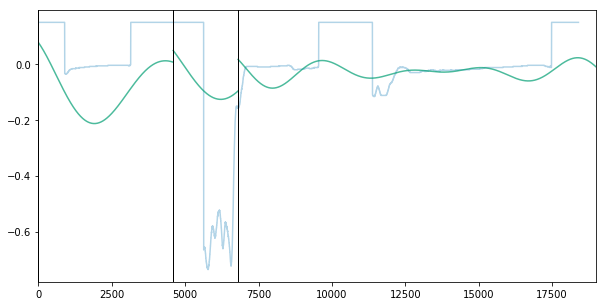

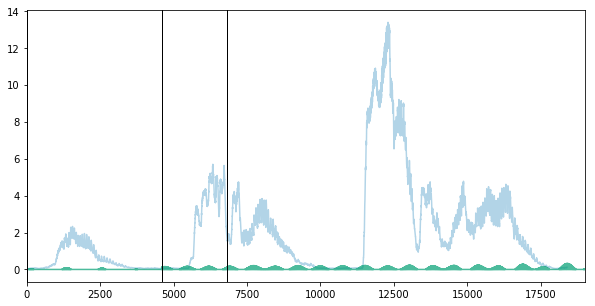

In [17]:
# Comparison between learnt beta and tutor's beta
plt.figure(figsize=(10, 5))
plt.plot(tutor_params[:, 1], alpha=0.3)
plt.plot(ab[:, 1], alpha=0.7)
plt.xlim(0, ab.shape[0])
for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1)
    

# Comparison between learnt alpha and tutor's alpha
plt.figure(figsize=(10, 5))
plt.plot(tutor_params[:, 0], alpha=0.3)
plt.plot(ab[:, 0], alpha=0.7)
plt.xlim(0, ab.shape[0])
for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1)

In [18]:
gtes = np.loadtxt('../data/{}_gte.dat'.format(basename(run_param['tutor']).split('.')[0]))
true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]

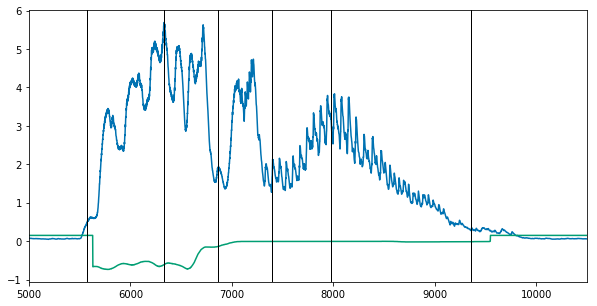

In [19]:
# Watching the gestures (alpha, beta) corresponding to the production of one syllable of the tutor
# ba_example parameters:
# x_min = 28000
# x_max = 35000

# boari_short parameters:
x_min = 5000
x_max = 10500

plt.figure(figsize=(10, 5))
plt.plot(np.arange(x_min, x_max), tutor_params[x_min:x_max])

# plt.plot(ab[:, 0], alpha=0.5)
plt.xlim(x_min, x_max)
#plt.xticks([])
#plt.yticks([])
for gte in true_gtes:
    start = gesture[0]
    plt.axvline(x=gte, color="k", linewidth=1)

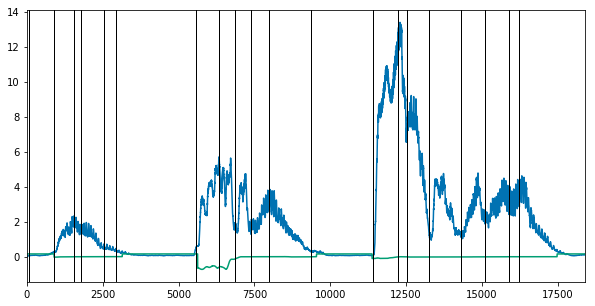

In [20]:
# (alpha, beta) + GTEs of all the tutor song
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, tutor_params.shape[0]), tutor_params)
# plt.plot(ab[:, 0], alpha=0.5)
plt.xlim(0, tutor_params.shape[0])
#plt.xticks([])
#plt.yticks([])
for gte in true_gtes:
    start = gesture[0]
    plt.axvline(x=gte, color="k", linewidth=1)

In [21]:
# number of gestures in a learnt song
len(smodels[0].gestures)

3

In [22]:
# numbers of gtes in the tutor song
len(true_gtes)

20

In [23]:
np.mean(np.diff(true_gtes))

851.4736842105264

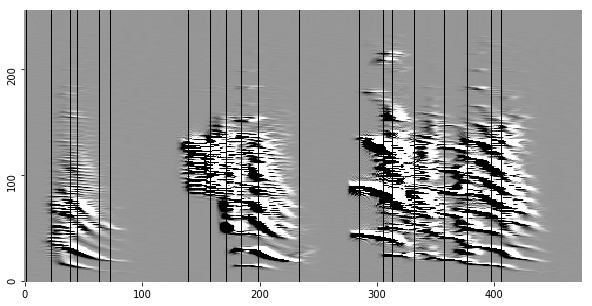

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
ax.set_xlim(0, ab.shape[0]/40)
for gte in true_gtes:
    ax.axvline(x=gte/40, color="k", linewidth=1)

# Analysis of the song log

In [25]:
if exists(join(path, 'aborted.txt')):
    warnings.warn('Aborted run')
if not exists(join(path, 'data.pkl')):
    warnings.warn('Run is not finished')


try:
    with open(join(path, 'data.pkl'), 'rb') as f:
        songlog = pickle.load(f)
except FileNotFoundError:
    warnings.warn('warning, learning not over')
    with open(join(path, 'data_cur.pkl'), 'rb') as f:
        songlog = pickle.load(f)

In [ ]:
# pretty print of the song log
# pprint(songlog)

In [26]:
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)
#Show the dataframe
# rd 

In [ ]:
# Useless for the moment. One Has to decomment the datasaver.add(..) lines in day_optimisers.py
# It allows to see each day optimisation with: the chosen song, the gesture chosen, the initial score of the song
# and the new score of the song after one simulated annealing optimization

# day_opt = pandas.DataFrame([elem[1] for elem in songlog if elem[0] == 'day_optim'])


Boari's score on boari_short.wav : 7.7748355198990495


/home/gnouveau/.virtualenvs/birdsong/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


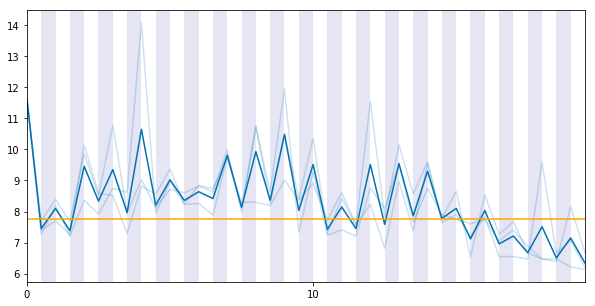

In [28]:
score_array = np.array([list(a) for a in rd['scores']]).T

full_name = run_param['tutor'].split('/')[-1]
name = full_name.split('.')[0]

sr, synth_song = wavfile.read('../data/{}_out.wav'.format(name))


# /!\: if tutor_feat parameter is defined, use rescaling to calculate the error
score = boari_synth_song_error(tutor, synth_song, run_param['coefs'],
                               tutor_feat=tfeat)

print("Boari's score on {}.wav : {}".format(name, score))

plt.figure(figsize=(10, 5))
for i in range(1, len(rd['scores']), 2):
    plt.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
sns.tsplot(score_array, err_style='unit_traces')
plt.xticks(range(0, len(rd['scores']), 20), range(0, len(rd['scores'])//2, 10))
plt.axhline(y=score, color='orange', linestyle='-')
plt.show()

In [29]:
print("first scores: {}".format(rd['scores'].iloc[0]))
print("last scores: {}".format(rd['scores'].iloc[-1]))
best = np.argmin(rd['scores'].iloc[-1])
print("the best song index: {}".format(best))

first scores: [11.62007333 11.62007333 11.62007333]
last scores: [6.21464336 6.68296011 6.13782482]
the best song index: 2


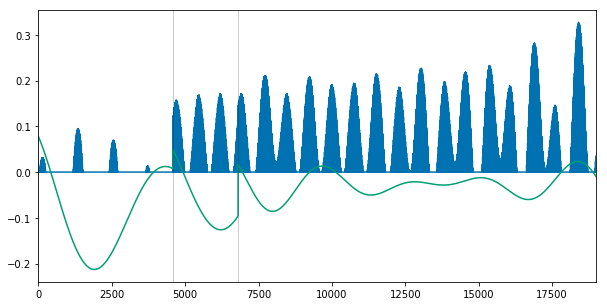

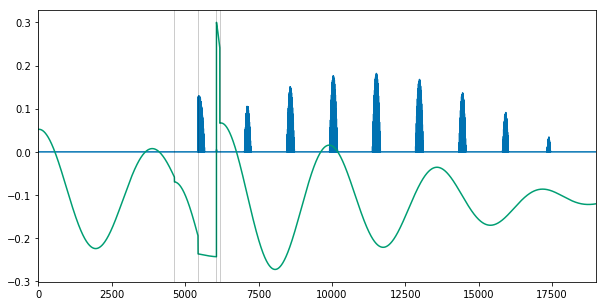

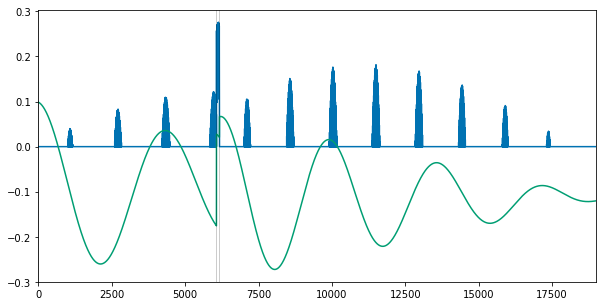

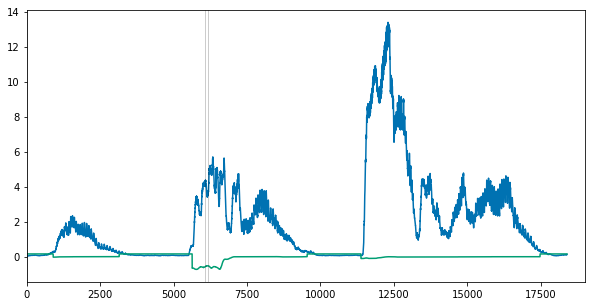

In [30]:
tutor_params = np.loadtxt('../data/{}_ab.dat'.format(basename(run_param['tutor']).split('.')[0]))

# plot the (alpha, beta) for the final songs and the (alpha, beta) of the tutor's song with the GTEs
for i in range(len(rd['songs'].iloc[-1])):
    plt.figure(figsize=(10, 5))
    ab = rd['songs'].iloc[-1][i].gen_alphabeta()
    plt.plot(ab)
    plt.xlim((0, ab.shape[0]))
    #plt.yticks([], [])
    for gesture in rd['songs'].iloc[-1][i].gestures:
        start = gesture[0]
        plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)

# Tutor song + gtes of the best optimised song
plt.figure(figsize=(10,5))
plt.plot(tutor_params)
plt.xlim((0, ab.shape[0]))
for gesture in rd['songs'].iloc[-1][best].gestures:
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.show()

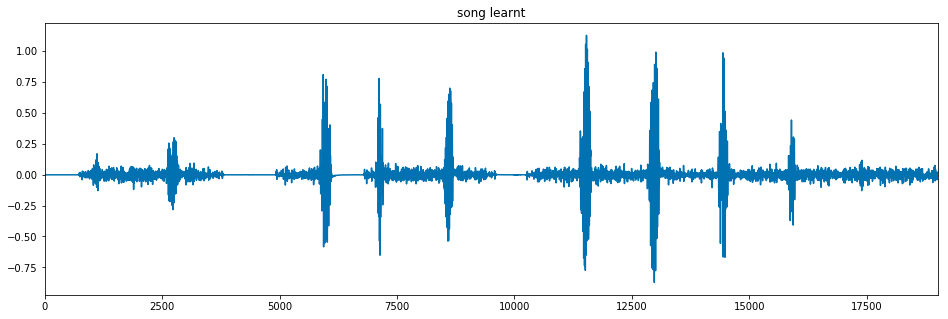

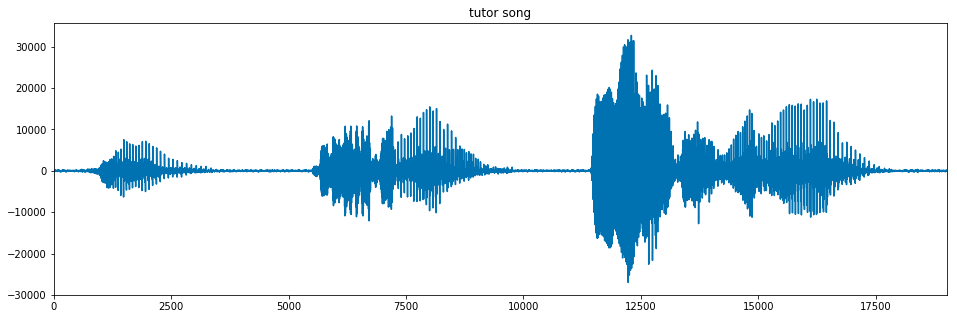

In [31]:
# sound of the best song_model
# %matplotlib notebook

plt.figure(figsize=(16, 5))
s = rd['songs'].iloc[-1][best].gen_sound(fixed_normalize=False)
plt.plot(s)
plt.xlim((0, len(s)))
plt.title("song learnt")
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(tutor)
plt.xlim((0, len(tutor)))
plt.title("tutor song")
plt.show()

### Learned

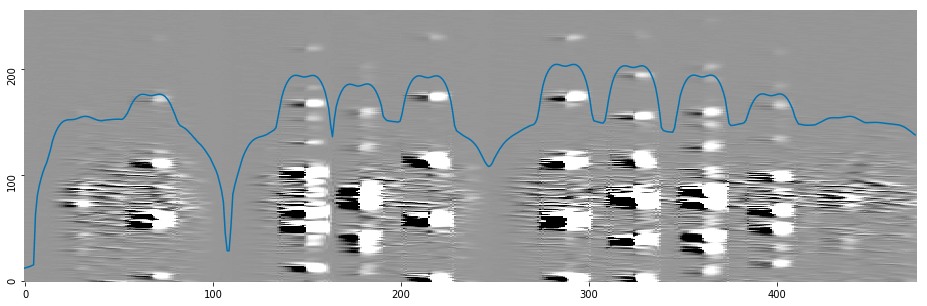

### Tutor

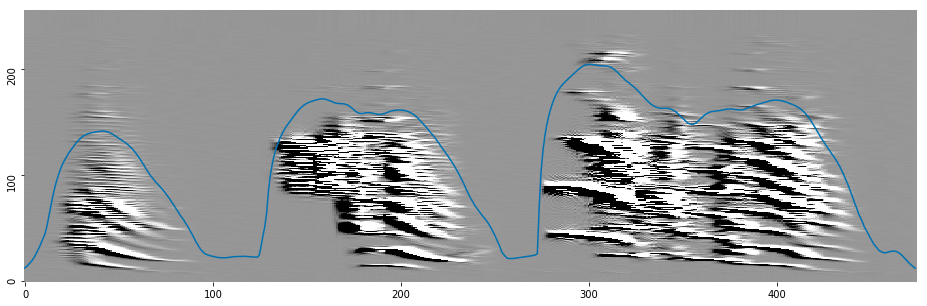

### Synthesized

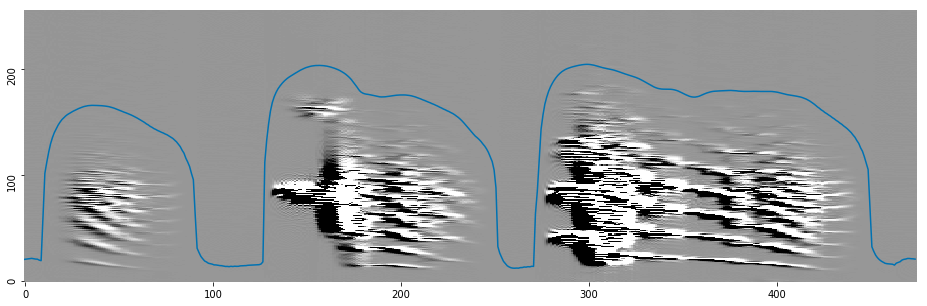

### test_fct

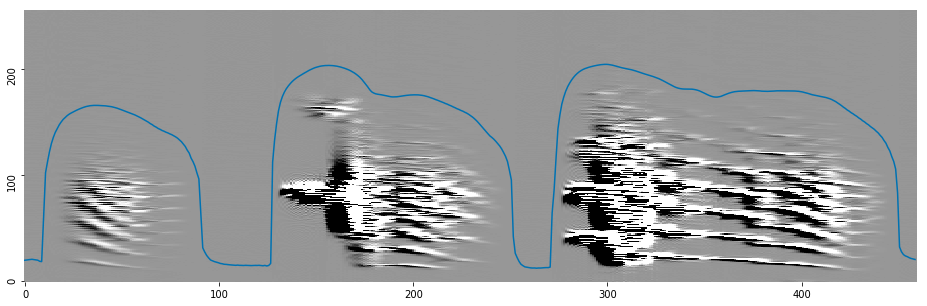

19012
19014
19014
18400


In [39]:
ab = rd['songs'].iloc[-1][best].gen_alphabeta()
s = synthesize(ab, fixed_normalize=False)

display(Markdown('### Learned'))
display(Audio(s, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(s, 256, 40, 1024), contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(s, 256, 40, 1024), ax=ax)
plt.show()

display(Markdown('### Tutor'))
display(Audio(tutor, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(tutor, 256, 40, 1024), contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
plt.show()

display(Markdown('### Synthesized'))
display(Audio(synth_song, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(synth_song, 256, 40, 1024), contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth_song, 256, 40, 1024), ax=ax)
plt.show()

print(len(s))
print(len(tutor))
print(len(synth_song))

# Save figures

In [ ]:
# from ipywidgets import widgets

In [ ]:
# textarea = widgets.Textarea()
# try:
#     with open(join(path, 'notes.md')) as f:
#         textarea.value = f.read()
# except FileNotFoundError:
#     pass
# display(textarea)
# button = widgets.Button(description="Save!")
# display(button)

# def on_button_clicked(b):
#     with open(join(path, 'notes.md'), 'w') as f:
#         f.write(textarea.value)
#     print('saved')

# button.on_click(on_button_clicked)


In [ ]:
# from measures import genetic_neighbours

In [ ]:
# genetic_neighbours([rd['songs'].iloc[-5][1]], rd['songs'].iloc[-5], 4000)

In [ ]:
# sm = rd.iloc[-1]['songs'][0]

In [ ]:
# sns.set_context('poster')
# sns.set_style('white')
# for i in [9]:
#     print(i)
#     plt.figure(figsize=(5* 1.61, 5))
#     plt.plot(sm.gen_alphabeta(range_=[i])[:, 0])
#     sns.despine()
#     plt.yticks([])
#     plt.xticks([])
#     plt.savefig('alpha.svg')
#     plt.show()
#     plt.close()
#     plt.figure(figsize=(10 * 1.61, 10))
#     plt.plot(sm.gen_alphabeta(range_=[i])[:, 1], color='g')
#     sns.despine()
#     plt.yticks([])
#     plt.xticks([])
#     plt.savefig('beta.svg')
#     plt.show()
#     plt.close()